- actual - 98.45
- 32, 64, 128, 256, 256 - Relu - Dense 256 - 128 - 98.36
- 32, 64, 128, 256, 256 - Relu - Dense 1024 - 98.66
- 32, 64, 128, 256, 256 - Mish - Dense 1024 - 98.16
- 32, 64, 128, 256, 256 - Mish - Dense 512 - 98.45
- 32, 64, 128, 256, 256 - LeakyRelu - Dense 1024 - 98.59
- 32, 64, 128, 256, 256 - LeakyRelu - AdamW - Dense 1024 - 98.59
- 32, 64, 128, 256, 256 - LeakyRelu - AdamW - 0.001 - Dense 1024 - 0.5 - 98.90
- 64, 64, 128, 128 - LeakyRelu - AdamW - 0.001 - Dense 1024 - 0.5 - 99.03
- 64, 64, 128, 128 - LeakyRelu - AdamW - 0.001 - Dense 512 - 0.5 - 96.38
- 64, 64, 128, 128 - LeakyRelu - AdamW - 0.001 - Dense 2048 - 0.5 - 
- 64, 64, 128, 128 - relu - AdamW - 0.001 - Dense 512 - No dropout - 98.58
- 32, 64, 128, 256, 128 - relu - AdamW - 0.001 - Dense 512 - 0.5 - 98.12
- 32, 64, 128, 256, 256 - LeakyRelu - SGD - Dense 1024 - 82.09
- 32, 64, 128, 256, 256 - LeakyRelu - Dense 512 - 98.42
-   
- 32, 64, 128, 256, 256 - hard_swish - Dense 1024 - 98.25
- 32, 64, 128, 256, 256 - hard_swish - Dense 512 - 98.36
- 32, 64, 128, 256, 256 - Swish - Dense 2048 - 512 - 97.69
- 16, 32, 64, 128, 128 - Dense 256 - 128 - *
- change projection_dim to 64 to 128 -
- Reduce patch size to 8×8 - 

# 1. Import the Libraries

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, Input, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold


2025-09-26 17:52:33.059705: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-26 17:52:33.059744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-26 17:52:33.059772: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Load Data

## 2.1 Without Augmentation

In [ ]:
# Paths
original_data_dir = "../data/external/1. Brain Tumor MRI Dataset(Kaggle)"  # Path to the original dataset
split_data_dir = "/split/BT/splitCV3"  # Directory to store split datasets
if not os.path.exists(split_data_dir):
    os.makedirs(split_data_dir)

# Function to clear directories
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # Remove the entire directory
    os.makedirs(directory, exist_ok=True)  # Recreate the directory

# Clear train, val, and test directories before splitting data
clear_directory(split_data_dir)

# Function to split the dataset into 10 folds and store them in `splitSSWE`
def prepare_splits(data_dir, split_dir, n_splits=10):
    if not os.path.exists(split_dir):
        os.makedirs(split_dir)

    # Get class names (only directories)
    class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    all_images = []

    # Collect all image paths and labels
    for label, class_name in enumerate(class_names):  # label is an integer index
        class_dir = os.path.join(data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if os.path.isfile(img_path):  # Ensure it's a file, not a directory or system file
                all_images.append((img_path, int(label)))  # Store integer label

    all_images = np.array(all_images, dtype=object)  # Ensure proper dtype for mixed types
    #np.random.shuffle(all_images)

    # Create KFold splits
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_idx = 0
    for train_idx, test_idx in kf.split(all_images):
        fold_dir = os.path.join(split_dir, f"fold_{fold_idx}")
        os.makedirs(fold_dir, exist_ok=True)
        train_dir = os.path.join(fold_dir, "train")
        test_dir = os.path.join(fold_dir, "test")
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # Copy training data
        for idx in train_idx:
            src, label = all_images[idx]
            class_name = class_names[label]  # Map integer label back to class name
            dest_dir = os.path.join(train_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src, dest_dir)

        # Copy testing data
        for idx in test_idx:
            src, label = all_images[idx]
            class_name = class_names[label]  # Map integer label back to class name
            dest_dir = os.path.join(test_dir, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            shutil.copy(src, dest_dir)

        fold_idx += 1


# Prepare splits (only needed once)
prepare_splits(original_data_dir, split_data_dir)

# 3. Initialize the Model

In [10]:
from tensorflow.keras import layers, models, applications

def create_model():
    base_model = applications.InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(168, 168, 3),
        pooling=None
    )
    
    model = models.Sequential(name="InceptionV3_CNN")
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.01))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))
    return model

model = create_model()
model.summary()


87910968/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 4)              

# 4. Model Training - Cross Fold Validation

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Perform 10-fold cross-validation
n_splits = 10
all_y_true = []  # To store true labels from all folds
all_y_pred = []  # To store predictions from all folds
fold_accuracies = []

for fold_idx in range(n_splits):
    print(f"Training Fold {fold_idx + 1}/{n_splits}")
    fold_dir = os.path.join(split_data_dir, f"fold_{fold_idx}")

    train_dir = os.path.join(fold_dir, "train")
    test_dir = os.path.join(fold_dir, "test")

    # Image Data Generators for train and test
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        # Add custom augmentations here
        horizontal_flip=True,
        rotation_range=2,  # Random rotation within 2 degrees
        brightness_range=[0.8, 1.2],  # Random contrast (brightness scaling)
        zoom_range=[0.95, 1.05],  # Random zoom between 95% and 105%
        width_shift_range=0.01,  # Random horizontal shift
        height_shift_range=0.01,  # Random vertical shift
    )

    test_datagen = ImageDataGenerator(rescale=1.0/255.0)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(168, 168),
        batch_size=32,
        class_mode='categorical'
    )
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(168, 168),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    # Create the model
    # model = hybrid_cnn_vit(input_shape=(224,224,3), num_classes=4)
    model = create_model()

    # ✅ Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
        loss='categorical_crossentropy',  # use 'sparse_categorical_crossentropy' if labels are integers
        metrics=['accuracy']
    )

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath=os.path.join(split_data_dir, f"best_model_fold_{fold_idx}.h5"), save_best_only=True)
    ]
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=test_generator,
        callbacks=[callbacks, lr_scheduler]
    )

    # Predict on the test set
    test_generator.reset()
    y_pred_prob = model.predict(test_generator)  # Get probabilities or logits
    y_pred = np.argmax(y_pred_prob, axis=1)  # Get the predicted class indices
    y_true = test_generator.classes  # True labels

    # Collect results for final classification report
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred_prob)

    # Calculate and store fold accuracy
    accuracy = accuracy_score(y_true, y_pred)
    fold_accuracies.append(accuracy)
    print(f"Accuracy for Fold {fold_idx + 1}: {accuracy:.4f}")


Training Fold 1/10
Found 6320 images belonging to 4 classes.
Found 703 images belonging to 4 classes.
Epoch 1/100
198/198 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.8489

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 67s 202ms/step - loss: 0.4895 - accuracy: 0.8489 - val_loss: 10.3567 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 38s 193ms/step - loss: 0.2209 - accuracy: 0.9282 - val_loss: 0.1166 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 36s 183ms/step - loss: 0.1472 - accuracy: 0.9497 - val_loss: 0.5551 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 185ms/step - loss: 0.1464 - accuracy: 0.9546 - val_loss: 0.3407 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 37s 188ms/step - loss: 0.1104 - accuracy: 0.9650 - val_loss: 0.4838 - val_accuracy: 0.8691 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1029 - accuracy: 0.9684 - val_loss: 0.2617 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - ET

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 60s 191ms/step - loss: 0.4809 - accuracy: 0.8483 - val_loss: 0.7889 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 37s 186ms/step - loss: 0.2176 - accuracy: 0.9290 - val_loss: 1.1469 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 38s 192ms/step - loss: 0.1553 - accuracy: 0.9502 - val_loss: 0.4738 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1469 - accuracy: 0.9524 - val_loss: 0.5547 - val_accuracy: 0.7824 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 38s 193ms/step - loss: 0.1058 - accuracy: 0.9663 - val_loss: 0.3155 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 188ms/step - loss: 0.1008 - accuracy: 0.9707 - val_loss: 0.3359 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 37s

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 62s 203ms/step - loss: 0.4358 - accuracy: 0.8517 - val_loss: 29.2580 - val_accuracy: 0.3912 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 39s 197ms/step - loss: 0.2081 - accuracy: 0.9353 - val_loss: 0.4325 - val_accuracy: 0.8990 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1804 - accuracy: 0.9451 - val_loss: 1.8203 - val_accuracy: 0.8706 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 185ms/step - loss: 0.1174 - accuracy: 0.9639 - val_loss: 11.9088 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 39s 196ms/step - loss: 0.1185 - accuracy: 0.9611 - val_loss: 0.2779 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 186ms/step - loss: 0.0861 - accuracy: 0.9725 - val_loss: 0.6485 - val_accuracy: 0.8321 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 3

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 65s 218ms/step - loss: 0.4995 - accuracy: 0.8415 - val_loss: 0.9420 - val_accuracy: 0.8348 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 38s 194ms/step - loss: 0.2956 - accuracy: 0.9049 - val_loss: 0.8817 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 39s 197ms/step - loss: 0.1805 - accuracy: 0.9411 - val_loss: 0.7387 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 39s 198ms/step - loss: 0.1284 - accuracy: 0.9612 - val_loss: 0.2187 - val_accuracy: 0.9202 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 37s 186ms/step - loss: 0.0824 - accuracy: 0.9736 - val_loss: 0.2309 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1617 - accuracy: 0.9519 - val_loss: 1.2847 - val_accuracy: 0.6994 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 37s

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 62s 200ms/step - loss: 0.4596 - accuracy: 0.8458 - val_loss: 1.7030 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 39s 199ms/step - loss: 0.2322 - accuracy: 0.9233 - val_loss: 0.8014 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1405 - accuracy: 0.9548 - val_loss: 1.0513 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 184ms/step - loss: 0.1858 - accuracy: 0.9461 - val_loss: 2.2883 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 38s 194ms/step - loss: 0.1163 - accuracy: 0.9655 - val_loss: 0.6677 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 38s 193ms/step - loss: 0.1206 - accuracy: 0.9639 - val_loss: 0.1774 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 37s

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 61s 199ms/step - loss: 0.4659 - accuracy: 0.8472 - val_loss: 0.6877 - val_accuracy: 0.8405 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 39s 196ms/step - loss: 0.2066 - accuracy: 0.9329 - val_loss: 0.4217 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 39s 195ms/step - loss: 0.1648 - accuracy: 0.9473 - val_loss: 0.1070 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 185ms/step - loss: 0.2846 - accuracy: 0.9166 - val_loss: 441569.6562 - val_accuracy: 0.3006 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 37s 184ms/step - loss: 0.3206 - accuracy: 0.9059 - val_loss: 55.4262 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 187ms/step - loss: 0.1493 - accuracy: 0.9551 - val_loss: 0.3961 - val_accuracy: 0.8903 - lr: 0.0010
Epoch 7/100
198/198 [==============================]

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 63s 208ms/step - loss: 0.4529 - accuracy: 0.8522 - val_loss: 270.0595 - val_accuracy: 0.3390 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 39s 197ms/step - loss: 0.2458 - accuracy: 0.9234 - val_loss: 0.2340 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 37s 187ms/step - loss: 0.1684 - accuracy: 0.9451 - val_loss: 131.0703 - val_accuracy: 0.5712 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 188ms/step - loss: 0.1702 - accuracy: 0.9435 - val_loss: 11410.5254 - val_accuracy: 0.2721 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 37s 185ms/step - loss: 0.2795 - accuracy: 0.9139 - val_loss: 0.3176 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 38s 194ms/step - loss: 0.1307 - accuracy: 0.9568 - val_loss: 0.2201 - val_accuracy: 0.9416 - lr: 0.0010
Epoch 7/100
198/198 [=============================

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 64s 209ms/step - loss: 0.4443 - accuracy: 0.8624 - val_loss: 1.5170 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 37s 186ms/step - loss: 0.2488 - accuracy: 0.9206 - val_loss: 2.2428 - val_accuracy: 0.5442 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 39s 197ms/step - loss: 0.2951 - accuracy: 0.9025 - val_loss: 0.2739 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 185ms/step - loss: 0.1965 - accuracy: 0.9394 - val_loss: 0.6158 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 38s 193ms/step - loss: 0.1321 - accuracy: 0.9595 - val_loss: 0.1045 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 37s 184ms/step - loss: 0.0938 - accuracy: 0.9671 - val_loss: 0.2222 - val_accuracy: 0.9217 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 37s

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 60s 199ms/step - loss: 0.5584 - accuracy: 0.8244 - val_loss: 0.4041 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 38s 194ms/step - loss: 0.2324 - accuracy: 0.9244 - val_loss: 0.3377 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 38s 193ms/step - loss: 0.1538 - accuracy: 0.9522 - val_loss: 0.2856 - val_accuracy: 0.9288 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 38s 192ms/step - loss: 0.1359 - accuracy: 0.9555 - val_loss: 0.1701 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 36s 183ms/step - loss: 0.1177 - accuracy: 0.9641 - val_loss: 0.3471 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 36s 183ms/step - loss: 0.0896 - accuracy: 0.9720 - val_loss: 0.2222 - val_accuracy: 0.9359 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - 36s

/home/mc1836@students.ad.unt.edu/miniconda3/envs/bt/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


198/198 [==============================] - 62s 201ms/step - loss: 0.5274 - accuracy: 0.8396 - val_loss: 286.9248 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - 39s 196ms/step - loss: 0.2788 - accuracy: 0.9117 - val_loss: 0.1472 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - 37s 185ms/step - loss: 0.1661 - accuracy: 0.9487 - val_loss: 0.3896 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 4/100
198/198 [==============================] - 37s 186ms/step - loss: 0.1294 - accuracy: 0.9617 - val_loss: 0.2146 - val_accuracy: 0.9088 - lr: 0.0010
Epoch 5/100
198/198 [==============================] - 36s 184ms/step - loss: 0.1168 - accuracy: 0.9616 - val_loss: 4.4348 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 6/100
198/198 [==============================] - 36s 184ms/step - loss: 0.1070 - accuracy: 0.9699 - val_loss: 0.3554 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 7/100
198/198 [==============================] - E

# 5. Results

In [12]:
# Create fold metrics DataFrame
fold_metrics = {
    "Fold": list(range(1, len(fold_accuracies) + 1)),
    "Accuracy": fold_accuracies
}
fold_metrics_df = pd.DataFrame(fold_metrics)

# Print the DataFrame in the VS Code terminal
print("\nFold-Wise Metrics:")
print(fold_metrics_df)


Fold-Wise Metrics:
   Fold  Accuracy
0     1  0.958748
1     2  0.991465
2     3  0.968706
3     4  0.992877
4     5  0.972934
5     6  0.978632
6     7  0.971510
7     8  0.988604
8     9  0.951567
9    10  0.954416


In [13]:
# Summary of Cross-Validation Results
print("\n10-Fold Cross-Validation Results")
print(f"Mean Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation: {np.std(fold_accuracies):.4f}")


10-Fold Cross-Validation Results
Mean Accuracy: 0.9729
Standard Deviation: 0.0143


In [14]:
from sklearn.metrics import accuracy_score

# Convert probability predictions into class labels (for accuracy)
all_y_pred_labels = np.argmax(np.array(all_y_pred), axis=1)  # Get class indices
all_y_true = np.array(all_y_true)  # Ensure correct format

# Calculate and print the overall test accuracy
overall_test_accuracy = accuracy_score(all_y_true, all_y_pred_labels)
print(f"\nOverall Test Accuracy: {overall_test_accuracy:.4f}")


Overall Test Accuracy: 0.9729


### 5.1 Classification Report

In [15]:
# Generate the final classification report
print("\nFinal Classification Report:")
class_labels = list(test_generator.class_indices.keys())  # Get class labels
print(classification_report(all_y_true, all_y_pred_labels, target_names=class_labels))


Final Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.95      0.97      1621
  meningioma       0.95      0.96      0.96      1645
     notumor       0.99      0.98      0.99      2000
   pituitary       0.97      0.99      0.98      1757

    accuracy                           0.97      7023
   macro avg       0.97      0.97      0.97      7023
weighted avg       0.97      0.97      0.97      7023



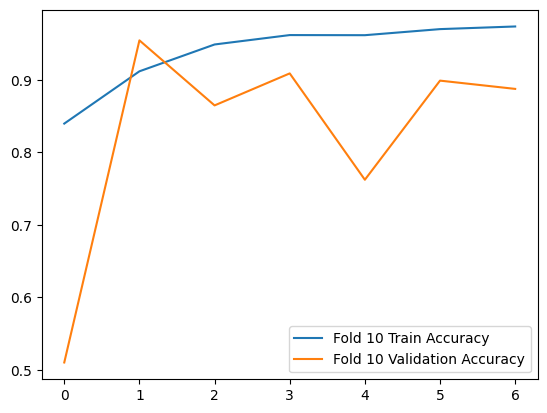

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label=f'Fold {fold_idx + 1} Train Accuracy')
plt.plot(history.history['val_accuracy'], label=f'Fold {fold_idx + 1} Validation Accuracy')
plt.legend()
plt.show()

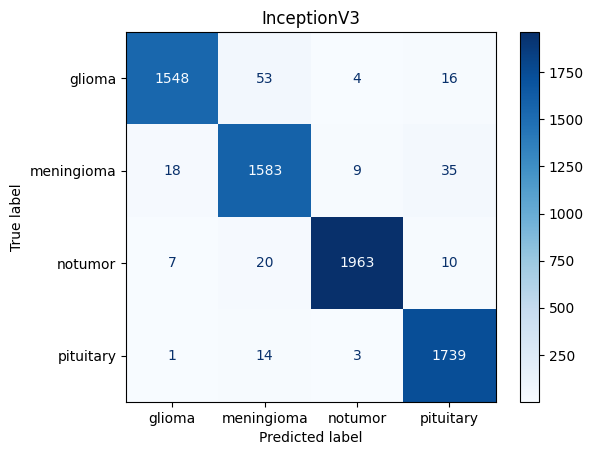

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix
cm = confusion_matrix(all_y_true, all_y_pred_labels)


# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap="Blues")  # Optional: Choose a color map
plt.title("InceptionV3")
plt.show()

In [18]:
print("y_pred_prob shape:", y_pred_prob.shape)  # Should be (num_samples, num_classes)
print("y_true shape:", len(y_true))  # Should match num_samples

y_pred_prob shape: (702, 4)
y_true shape: 702


all_y_true_one_hot shape: (7023, 4)
all_y_pred_prob shape: (7023, 4)


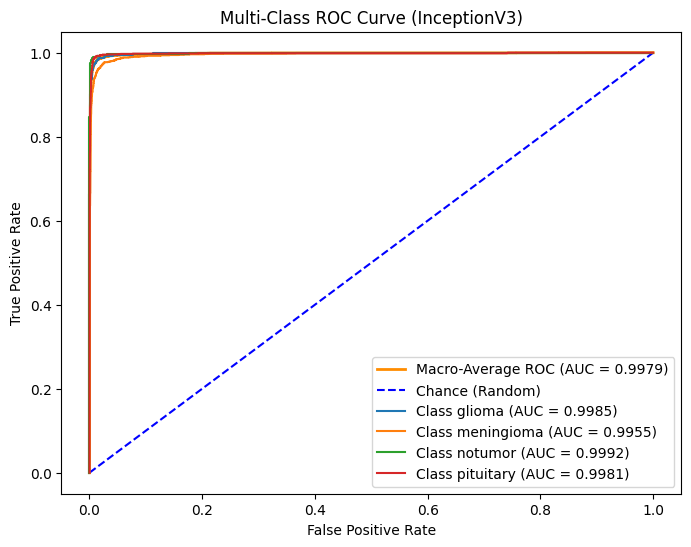

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert true labels to one-hot encoding for multi-class ROC curve
num_classes = len(class_labels)
all_y_true_one_hot = label_binarize(all_y_true, classes=np.arange(num_classes))
all_y_pred_prob = np.array(all_y_pred)  # Ensure predictions are in NumPy array format

# Check shapes
print("all_y_true_one_hot shape:", all_y_true_one_hot.shape)
print("all_y_pred_prob shape:", all_y_pred_prob.shape)

# Initialize dictionaries for ROC curve data
fpr, tpr, roc_auc = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_y_true_one_hot[:, i], all_y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(all_y_true_one_hot.ravel(), all_y_pred_prob.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-Average ROC (AUC = {roc_auc["macro"]:.4f})', color='darkorange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='blue', label='Chance (Random)')

# Plot ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_labels[i]} (AUC = {roc_auc[i]:.4f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (InceptionV3)')
plt.legend(loc='lower right')
plt.show()

In [20]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Collect metrics
# Overall metrics after cross-validation
precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred_labels, average='weighted')
overall_metrics = {
    "Metric": ["Mean", "SD", "Test Accuracy", "Precision", "Recall", "F1-Score"],
    "Value": [
        np.mean(fold_accuracies),
        np.std(fold_accuracies),
        overall_test_accuracy,
        precision,
        recall,
        f1
    ]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(overall_metrics)

# Save metrics to a CSV file
output_dir = "../models/model_logs"
os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
metrics_file = os.path.join(output_dir, "1db_kaggle_custom_performance_metrics.csv")
metrics_df.to_csv(metrics_file, index=False)

print(f"Metrics saved to '{metrics_file}'")


Metrics saved to '../models/model_logs/1db_kaggle_custom_performance_metrics.csv'


In [21]:
df = pd.read_csv(metrics_file)
print(df.head())

          Metric     Value
0           Mean  0.972946
1             SD  0.014282
2  Test Accuracy  0.972946
3      Precision  0.973204
4         Recall  0.972946


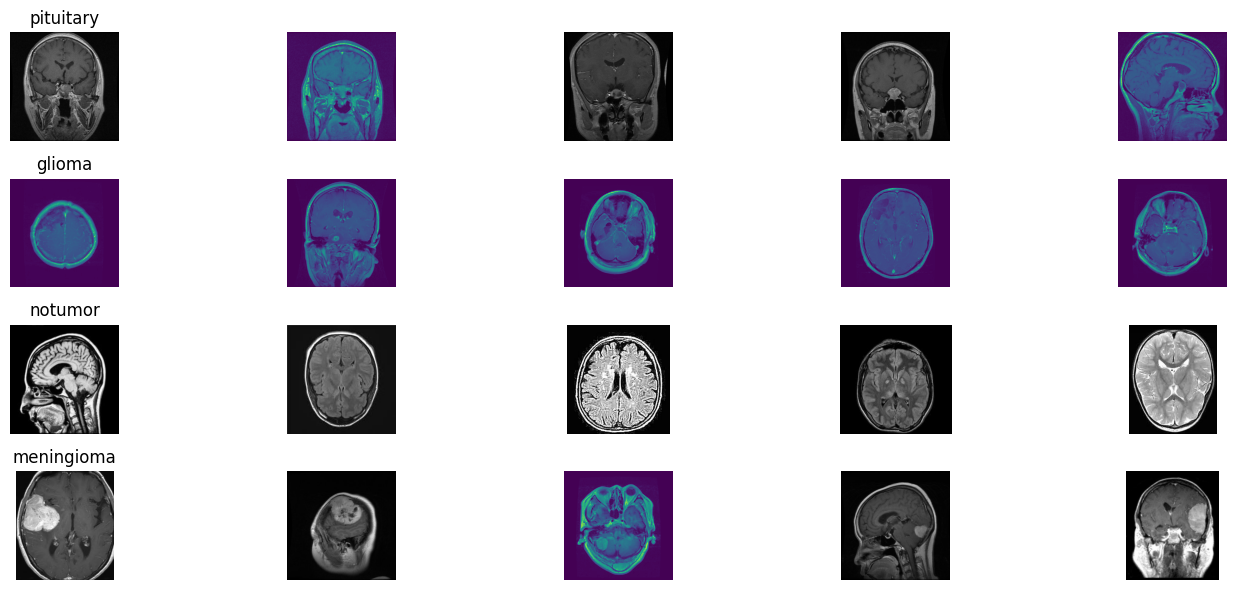

In [22]:
import random
import matplotlib.image as mpimg

# Set your main directory path
main_dir = original_data_dir  # Change this to your actual dataset directory

# Get the class names (folder names)
classes = [d for d in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, d))]

# Define the number of images to display per class
num_images = 5

plt.figure(figsize=(15, 6))

# Loop through each class
for idx, class_name in enumerate(classes):
    class_path = os.path.join(main_dir, class_name)
    
    # Get all image files in the class directory
    images = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Randomly select 5 images
    selected_images = random.sample(images, min(num_images, len(images)))
    
    # Display the images
    for j, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)
        
        plt.subplot(len(classes), num_images, idx * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name if j == 0 else "")
        
plt.tight_layout()
plt.show()
